In [1]:
from train_test import train, test

from sklearn.model_selection import train_test_split
import torch
import numpy as np
import pandas as pd
from torch import nn
import torch
import torch.nn.functional as F
import math

import matplotlib.pyplot as plt
import seaborn as sns

import pylab as pl

from dateutil.relativedelta import relativedelta

import shap

from captum.attr import IntegratedGradients

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score

In [3]:
def output_to_accu(model, X, y):
    model.eval()
    prob = model(X).cpu().detach().numpy()
    pred = (prob >= 0.5).astype(int)
    nb_errors = 0
    for b in range(0, X.size(0)):
        if pred[b] != y[b]:
            nb_errors = nb_errors + 1
    accuracy = 100 * (1 - nb_errors / X.size(0))
    return accuracy

In [4]:
def good_bad_pred(model, X_test, y_test):
    model.eval()
    prob = model(X_test).detach().numpy()
    pred = (prob >= 0.5).astype(int)
    return (pred == y_test.detach().numpy()).astype(int)

In [5]:
def fast_fracdiff(x, d):

    T = len(x)
    np2 = int(2 ** np.ceil(np.log2(2 * T - 1)))
    k = np.arange(1, T)
    b = (1,) + tuple(np.cumprod((k - d - 1) / k))
    z = (0,) * (np2 - T)
    z1 = b + z
    z2 = tuple(x) + z
    dx = pl.ifft(pl.fft(z1) * pl.fft(z2))
    return np.real(dx[0:T])

In [6]:
red = sns.color_palette('RdYlGn', 10)[0]
green = sns.color_palette('RdYlGn', 10)[-1]
pal = [red, green]

# DATA

In [7]:
data = pd.read_excel('data/data.xlsx', index_col=0, skiprows=[0, 1, 2, 3, 4, 5, 6, 8], sheet_name='features').fillna(method='ffill').shift(1).iloc[1:]
data = data.astype(float)

data['MATERIALS'] *= data['EURCHF']
data['CONSUMER STAPLE'] *= data['EURCHF']
data['INDUSTRIALS'] *= data['EURCHF']
data['CONSUMER DIS.'] *= data['EURCHF']
data['HEALTH CARE'] *= data['EURCHF']
data['FINANCIALS'] *= data['EURCHF']

data['GOLD'] *= data['USDCHF']
data['SILVER'] *= data['USDCHF']
data['BRENT'] *= data['USDCHF']
data['SP500'] *= data['USDCHF']
data['RUSSELL 2000'] *= data['USDCHF']

data.head()

,SPI,SMALL_MID,LARGE,MATERIALS,CONSUMER STAPLE,INDUSTRIALS,CONSUMER DIS.,HEALTH CARE,FINANCIALS,EURCHF,USDCHF,US 2YEAR,US 5YEAR,US 10YEAR,GOLD,SILVER,BRENT,SP500,RUSSELL 2000,SURPRISE
2006-01-05,5851.15,1508.31,5833.18,276.409672,174.241453,218.695382,140.386529,175.355509,174.721116,1.54730,1.2760,4.304,4.277,4.344,679.214800,11.605220,78.703680,1624.934960,879.509796,24.4
2006-01-06,5837.78,1509.53,5818.60,272.864640,172.733945,217.021928,139.568162,175.452705,173.846165,1.54475,1.2772,4.321,4.284,4.354,672.828960,11.181886,78.075236,1626.488656,883.552911,28.2
2006-01-09,5850.81,1516.33,5828.32,274.390587,173.003134,217.791843,140.132384,175.331222,174.622003,1.54178,1.2702,4.354,4.316,4.375,685.399920,11.463555,79.666944,1632.778590,888.382961,25.3
2006-01-10,5849.79,1518.68,5823.36,274.741194,172.954918,217.963610,140.964506,175.453688,175.052650,1.54245,1.2769,4.345,4.302,4.367,699.485820,11.715558,79.180569,1647.392535,901.822117,26.3
2006-01-11,5811.98,1512.24,5785.15,271.683725,173.365830,217.371702,140.438683,174.153856,173.844827,1.54515,1.2807,4.395,4.358,4.426,694.241856,11.468668,79.300944,1651.705983,910.590507,26.4


In [8]:
target_prices = data[['SMALL_MID', 'LARGE']]
target_prices.head()

,SMALL_MID,LARGE
2006-01-05,1508.31,5833.18
2006-01-06,1509.53,5818.60
2006-01-09,1516.33,5828.32
2006-01-10,1518.68,5823.36
2006-01-11,1512.24,5785.15


In [9]:
bench_price = data['SPI']
raw_features = data[data.columns.difference(['SPI', 'EURCHF', 'USDCHF'])]
raw_features.head()

,BRENT,CONSUMER DIS.,CONSUMER STAPLE,FINANCIALS,GOLD,HEALTH CARE,INDUSTRIALS,LARGE,MATERIALS,RUSSELL 2000,SILVER,SMALL_MID,SP500,SURPRISE,US 10YEAR,US 2YEAR,US 5YEAR
2006-01-05,78.703680,140.386529,174.241453,174.721116,679.214800,175.355509,218.695382,5833.18,276.409672,879.509796,11.605220,1508.31,1624.934960,24.4,4.344,4.304,4.277
2006-01-06,78.075236,139.568162,172.733945,173.846165,672.828960,175.452705,217.021928,5818.60,272.864640,883.552911,11.181886,1509.53,1626.488656,28.2,4.354,4.321,4.284
2006-01-09,79.666944,140.132384,173.003134,174.622003,685.399920,175.331222,217.791843,5828.32,274.390587,888.382961,11.463555,1516.33,1632.778590,25.3,4.375,4.354,4.316
2006-01-10,79.180569,140.964506,172.954918,175.052650,699.485820,175.453688,217.963610,5823.36,274.741194,901.822117,11.715558,1518.68,1647.392535,26.3,4.367,4.345,4.302
2006-01-11,79.300944,140.438683,173.365830,173.844827,694.241856,174.153856,217.371702,5785.15,271.683725,910.590507,11.468668,1512.24,1651.705983,26.4,4.426,4.395,4.358


In [10]:
return_corr_matrix = raw_features.pct_change().corr()
return_corr_matrix[return_corr_matrix > 0.8]

,BRENT,CONSUMER DIS.,CONSUMER STAPLE,FINANCIALS,GOLD,HEALTH CARE,INDUSTRIALS,LARGE,MATERIALS,RUSSELL 2000,SILVER,SMALL_MID,SP500,SURPRISE,US 10YEAR,US 2YEAR,US 5YEAR
BRENT,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CONSUMER DIS.,NaN,1.000000,NaN,0.809163,NaN,NaN,0.870851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CONSUMER STAPLE,NaN,NaN,1.000000,NaN,NaN,0.813139,NaN,0.830034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FINANCIALS,NaN,0.809163,NaN,1.000000,NaN,NaN,0.891722,NaN,0.837238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GOLD,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HEALTH CARE,NaN,NaN,0.813139,NaN,NaN,1.000000,NaN,0.854937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
INDUSTRIALS,NaN,0.870851,NaN,0.891722,NaN,NaN,1.000000,0.822831,0.906584,NaN,NaN,0.866166,NaN,NaN,NaN,NaN,NaN
LARGE,NaN,NaN,0.830034,NaN,NaN,0.854937,0.822831,1.000000,NaN,NaN,NaN,0.839560,NaN,NaN,NaN,NaN,NaN
MATERIALS,NaN,NaN,NaN,0.837238,NaN,NaN,0.906584,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RUSSELL 2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.921728,NaN,NaN,NaN,NaN


In [11]:
raw_features = raw_features.drop(columns=['US 5YEAR', 'RUSSELL 2000', 'INDUSTRIALS'])
raw_features.head()

,BRENT,CONSUMER DIS.,CONSUMER STAPLE,FINANCIALS,GOLD,HEALTH CARE,LARGE,MATERIALS,SILVER,SMALL_MID,SP500,SURPRISE,US 10YEAR,US 2YEAR
2006-01-05,78.703680,140.386529,174.241453,174.721116,679.214800,175.355509,5833.18,276.409672,11.605220,1508.31,1624.934960,24.4,4.344,4.304
2006-01-06,78.075236,139.568162,172.733945,173.846165,672.828960,175.452705,5818.60,272.864640,11.181886,1509.53,1626.488656,28.2,4.354,4.321
2006-01-09,79.666944,140.132384,173.003134,174.622003,685.399920,175.331222,5828.32,274.390587,11.463555,1516.33,1632.778590,25.3,4.375,4.354
2006-01-10,79.180569,140.964506,172.954918,175.052650,699.485820,175.453688,5823.36,274.741194,11.715558,1518.68,1647.392535,26.3,4.367,4.345
2006-01-11,79.300944,140.438683,173.365830,173.844827,694.241856,174.153856,5785.15,271.683725,11.468668,1512.24,1651.705983,26.4,4.426,4.395


In [12]:
technical_features = raw_features[raw_features.columns.difference(['SURPRISE'])]

mom5 = technical_features.rolling(5).apply(lambda x: np.log(x[-1] / x[0]) / len(x))
mom5 = mom5.add_suffix(' mom5')

mom21 = technical_features.rolling(21).apply(lambda x: np.log(x[-1] / x[0]) / len(x))
mom21 = mom21.add_suffix(' mom21')

mom63 = technical_features.rolling(63).apply(lambda x: np.log(x[-1] / x[0]) / len(x))
mom63 = mom63.add_suffix(' mom63')

ema_12 = technical_features.ewm(span=12).mean()
ema_26 = technical_features.ewm(span=26).mean()
MACD = (ema_12 - ema_26) - (ema_12 - ema_26).ewm(span=9).mean()
MACD = MACD.add_suffix(' MACD')

# raw_features['SURPRISE'] = fast_fracdiff(raw_features['SURPRISE'], 0.5)

features = pd.concat([mom5, mom21, mom63, MACD, raw_features['SURPRISE']], axis=1).ewm(5).mean().dropna()
features.head(1)

,BRENT mom5,CONSUMER DIS. mom5,CONSUMER STAPLE mom5,FINANCIALS mom5,GOLD mom5,HEALTH CARE mom5,LARGE mom5,MATERIALS mom5,SILVER mom5,SMALL_MID mom5,SP500 mom5,US 10YEAR mom5,US 2YEAR mom5,BRENT mom21,CONSUMER DIS. mom21,CONSUMER STAPLE mom21,FINANCIALS mom21,GOLD mom21,HEALTH CARE mom21,LARGE mom21,MATERIALS mom21,SILVER mom21,SMALL_MID mom21,SP500 mom21,US 10YEAR mom21,US 2YEAR mom21,BRENT mom63,CONSUMER DIS. mom63,CONSUMER STAPLE mom63,FINANCIALS mom63,GOLD mom63,HEALTH CARE mom63,LARGE mom63,MATERIALS mom63,SILVER mom63,SMALL_MID mom63,SP500 mom63,US 10YEAR mom63,US 2YEAR mom63,BRENT MACD,CONSUMER DIS. MACD,CONSUMER STAPLE MACD,FINANCIALS MACD,GOLD MACD,HEALTH CARE MACD,LARGE MACD,MATERIALS MACD,SILVER MACD,SMALL_MID MACD,SP500 MACD,US 10YEAR MACD,US 2YEAR MACD,SURPRISE
2006-04-03,0.004831,0.000693,-0.000726,0.000012,0.003677,-0.000045,-0.000138,0.002142,0.0075,0.001734,-0.000306,0.002904,0.00222,0.001469,0.001651,0.000605,0.000916,0.000493,0.00206,0.000582,0.00149,0.004987,0.001987,0.00034,0.001733,0.000656,0.0014,0.001239,0.00069,0.00157,0.001787,0.000537,0.000648,0.001759,0.004147,0.001972,0.000611,0.001746,0.001797,0.291439,0.203785,-0.248027,-0.101876,1.674236,0.131107,-2.128181,0.644076,0.070159,1.788564,-0.247298,0.001574,0.001126,-5.650111


In [13]:
features = features.drop(columns=['FINANCIALS mom5', 'GOLD mom5', 'HEALTH CARE mom5',  'MATERIALS mom5',  'SILVER mom5',  'SMALL_MID mom5',  'US 10YEAR mom5',  'CONSUMER STAPLE mom21',  'GOLD mom21',  'SMALL_MID mom21',  'US 10YEAR mom21',  'US 2YEAR mom21',  'CONSUMER STAPLE mom63',  'FINANCIALS mom63',  'HEALTH CARE mom63',  'LARGE mom63',  'SILVER mom63',  'SMALL_MID mom63',  'US 10YEAR mom63', 'US 2YEAR mom63',])

In [14]:
features = features.drop(columns=[ 'CONSUMER STAPLE mom5', 'LARGE mom5', 'CONSUMER DIS. mom21',  'SILVER mom21',  'BRENT mom63', 'GOLD mom63',  'MATERIALS mom63',  'CONSUMER DIS. MACD', 'SILVER MACD'])

In [15]:
corr_matrix = features.corr()
corr_matrix[corr_matrix > 0.85]

,BRENT mom5,CONSUMER DIS. mom5,SP500 mom5,US 2YEAR mom5,BRENT mom21,FINANCIALS mom21,HEALTH CARE mom21,LARGE mom21,MATERIALS mom21,SP500 mom21,CONSUMER DIS. mom63,SP500 mom63,BRENT MACD,CONSUMER STAPLE MACD,FINANCIALS MACD,GOLD MACD,HEALTH CARE MACD,LARGE MACD,MATERIALS MACD,SMALL_MID MACD,SP500 MACD,US 10YEAR MACD,US 2YEAR MACD,SURPRISE
BRENT mom5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CONSUMER DIS. mom5,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SP500 mom5,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
US 2YEAR mom5,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BRENT mom21,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FINANCIALS mom21,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HEALTH CARE mom21,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.867706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LARGE mom21,NaN,NaN,NaN,NaN,NaN,NaN,0.867706,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MATERIALS mom21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SP500 mom21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [169]:
training_window = 4

last_date_train = target_prices.index[-1]

forward_weekly_returns = target_prices.rolling(5).apply(lambda x: np.log(x[-1] / x[0]) / len(x)).shift(-5)
forward_weekly_returns['abs_diff'] = np.abs(forward_weekly_returns.SMALL_MID - forward_weekly_returns.LARGE)

best_pred = (forward_weekly_returns.SMALL_MID > forward_weekly_returns.LARGE).astype(int)
best_pred = best_pred[forward_weekly_returns.abs_diff > 0.0005]

start_date = last_date_train - relativedelta(years=training_window)

df_output = best_pred.loc[start_date:last_date_train]
df_input = features.reindex(df_output.index)

X = df_input.values
y = df_output.values

index = df_input.index

X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float()

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size= 0.2, shuffle=False)
print('Number of train sample :', len(X_train))
print('Number of test sample :', len(X_test))

class_count_train = np.unique(y_train, axis=0, return_counts=True)[1]
class_count_test = np.unique(y_test, axis=0, return_counts=True)[1]
weights_train = class_count_train / sum(class_count_train)
weights_test = class_count_test / sum(class_count_test)
print('Allocation of best returns in train set :', weights_train)
print('Allocation of best returns in test set :', weights_test)

Number of train sample : 677
Number of test sample : 170
Allocation of best returns in train set : [0.483 0.517]
Allocation of best returns in test set : [0.559 0.441]


logit_model = LogisticRegression(max_iter=1000, penalty = 'l2', solver='sag', tol=1e-7)
logit_model.fit(X_train, y_train)
y_hat = logit_model.predict(X_test)
y_hat_prob = logit_model.predict_proba(X_test)

y_hat_logit_train = logit_model.predict(X_train)
y_hat_logit_test = logit_model.predict(X_test)

print('Accuracy on train set', round(100 * accuracy_score(y_hat_logit_train, y_train), 2), '%')
print('Accuracy on test set', round(100 * accuracy_score(y_hat_logit_test, y_test), 2), '%')

class_count_train = np.unique(y_hat_logit_train, axis=0, return_counts=True)[1]
class_count_test = np.unique(y_hat_logit_test, axis=0, return_counts=True)[1]
weights_train = class_count_train / sum(class_count_train)
weights_test = class_count_test / sum(class_count_test)
print('Rate of small predictions in train set :', round(weights_train[0], 4) * 100, '%')
print('Rate of small predictions in test set :', round(weights_test[0], 4) * 100, '%')

betas = logit_model.coef_.reshape(-1)
std = np.std(X_train, axis=0)

fig, ax = plt.subplots(figsize=(10, 20))
sns.barplot(y=features.columns, x=np.divide(betas, std), color='r')
ax.tick_params(labelsize=6, length=0)
plt.title('Global Feature importance for a Logistic Regression model')
plt.show()

# Random Forest

In [171]:
from sklearn.ensemble import RandomForestClassifier

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size= 0.2, shuffle=False)

In [173]:
rfc = RandomForestClassifier(criterion='gini', max_depth=None, min_samples_leaf=10, 
                             min_samples_split=10, n_estimators= 1000)

rfc = rfc.fit(X_train, y_train)
y_hat_rfc_train = rfc.predict(X_train)
y_hat_rfc_test = rfc.predict(X_test)

print('Accuracy on train set', round(100 * accuracy_score(y_hat_rfc_train, y_train), 2), '%')
print('Accuracy on test set', round(100 * accuracy_score(y_hat_rfc_test, y_test), 2), '%')

Accuracy on train set 92.32 %
Accuracy on test set 57.65 %


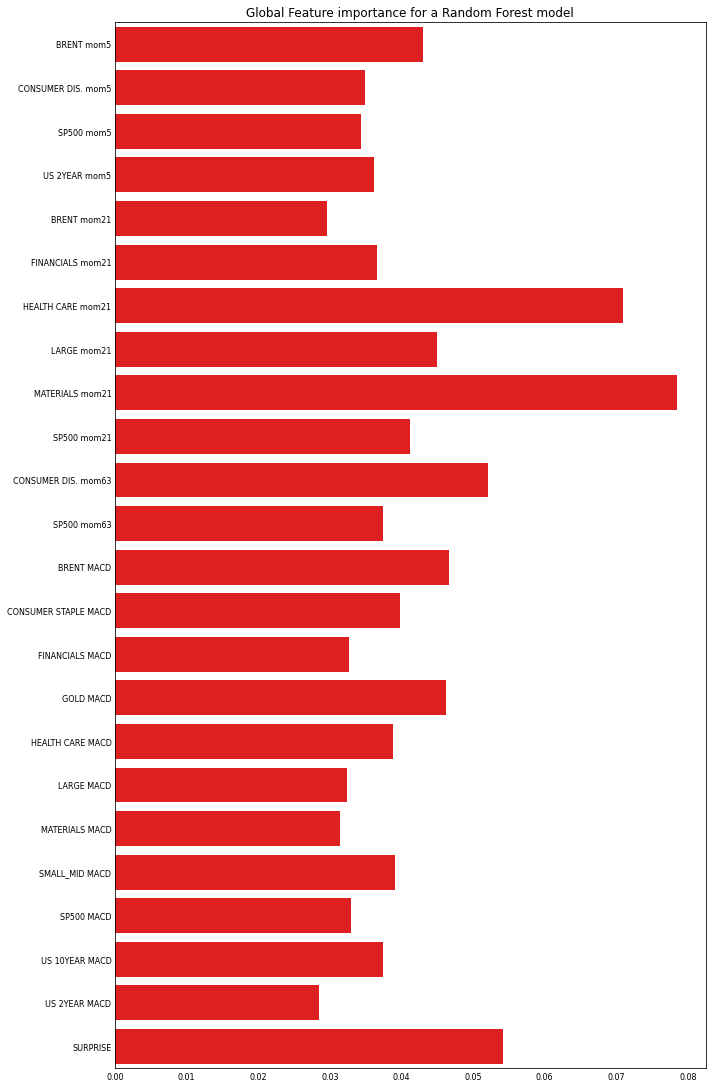

In [174]:
importances = rfc.feature_importances_

fig, ax = plt.subplots(figsize=(10, 15))
sns.barplot(y=features.columns, x=importances, color='r')
ax.tick_params(labelsize=8, length=0)
plt.tight_layout()
plt.title('Global Feature importance for a Random Forest model')
plt.show()

In [176]:
explainer = shap.TreeExplainer(rfc)
shap_values_train = np.mean(explainer.shap_values(X_test), axis=0)
shap_values_test = np.mean(explainer.shap_values(X_test), axis=0)

In [181]:
shap_values_train.mean(axis=0)

array([ 0.,  0.,  0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

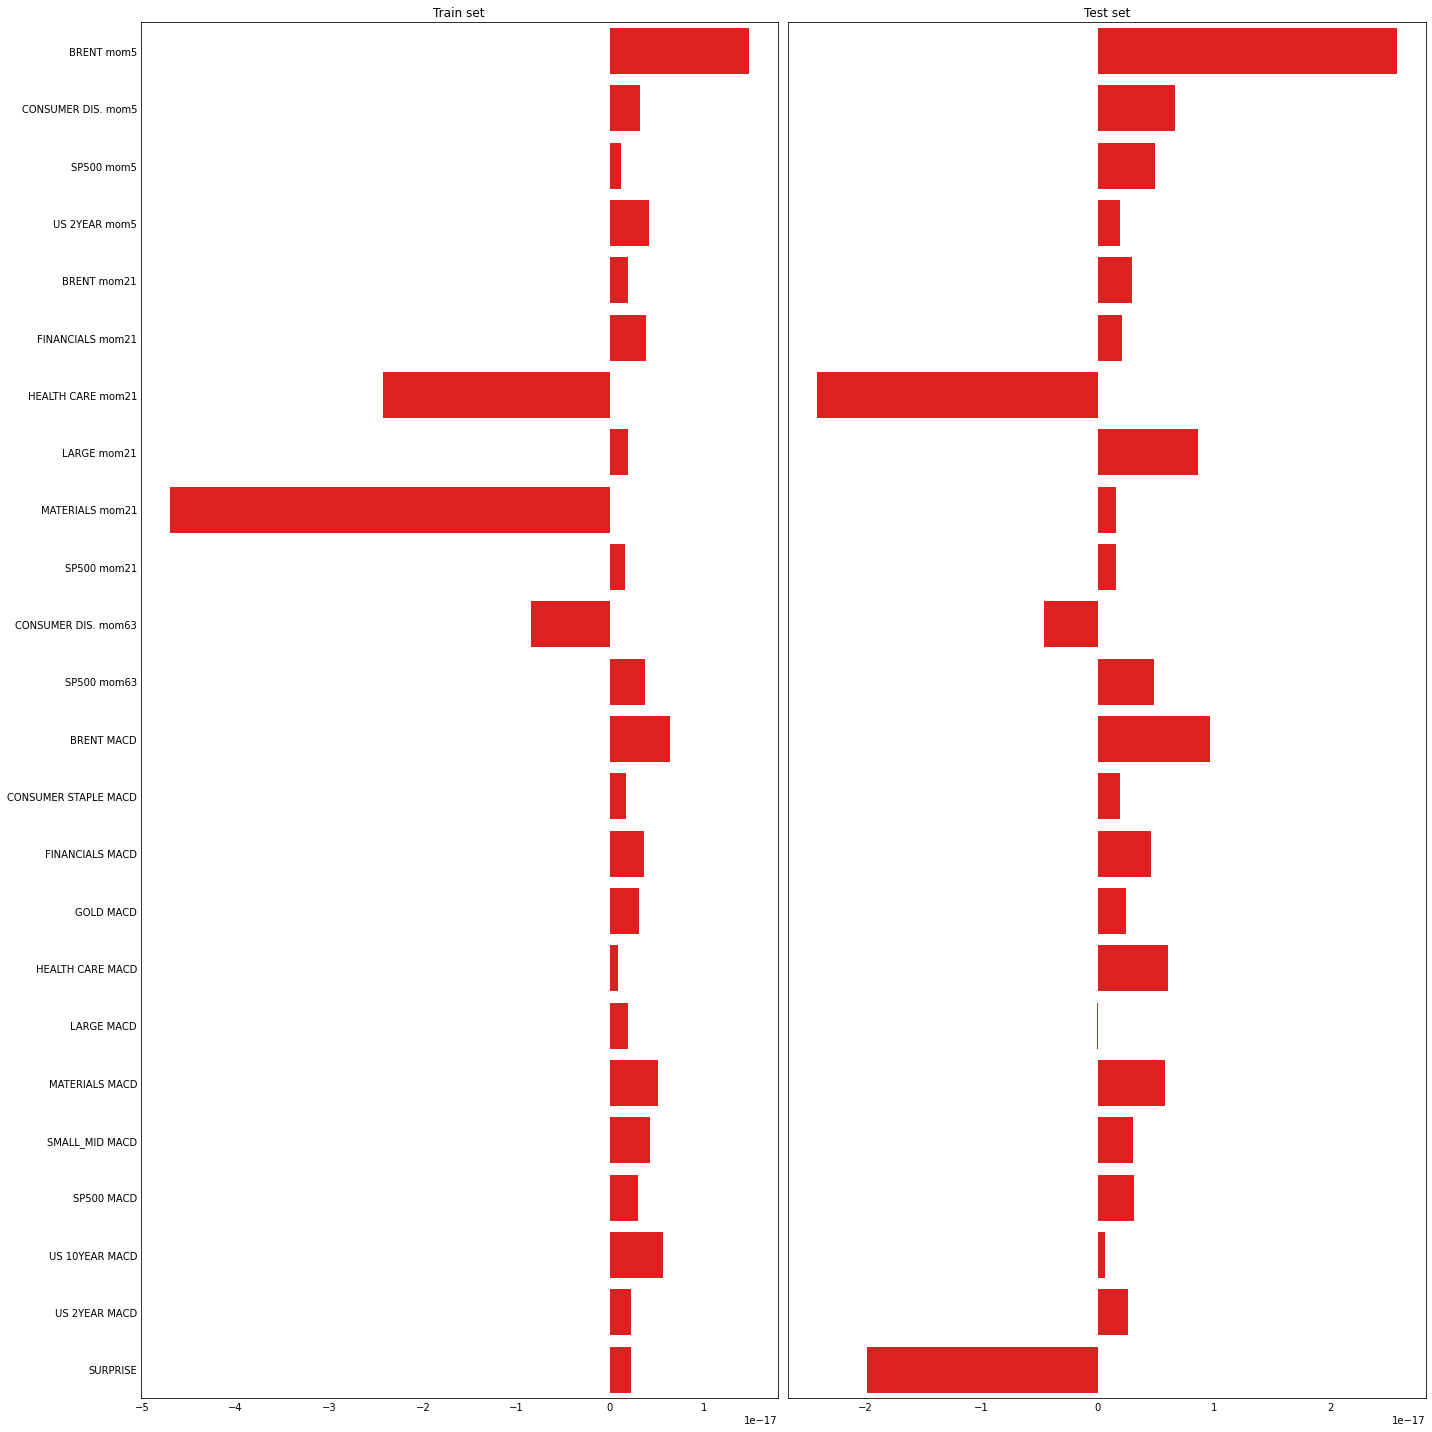

In [182]:
fig, axs = plt.subplots(1, 2, figsize=(20, 20), sharey=True)

sns.barplot(ax=axs[0], x=shap_values_train.mean(axis=0), y=features.columns, color='r')
axs[0].tick_params(length=0)
axs[0].set_title('Train set')

sns.barplot(ax=axs[1], x=shap_values_test.mean(axis=0), y=features.columns, color='r')
axs[1].tick_params(length=0)
axs[1].set_title('Test set')

plt.tight_layout()
plt.show()

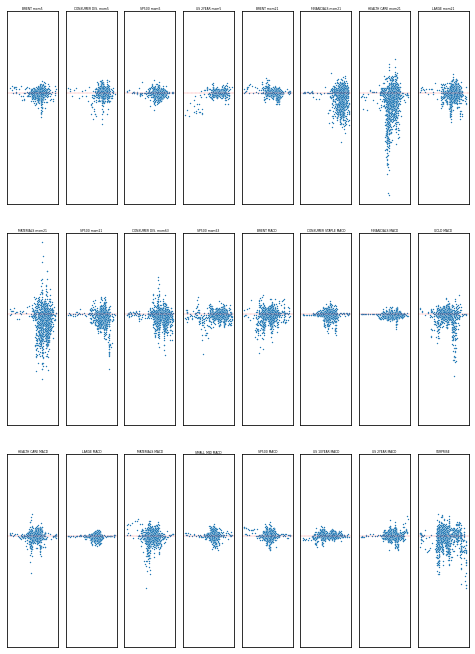

In [95]:
explainer = shap.TreeExplainer(rfc)
shap_values = shap_values_train

fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(8.27, 11.69), sharex=False, sharey=True)

axs = axs.ravel()

for i, feature in enumerate(features.columns):
    sns.scatterplot(ax=axs[i], x=X_train[:, i], y=shap_values[:, i], s=2)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(feature, fontsize=3, pad=2)

plt.subplots_adjust(wspace=0.15, hspace=0.15)
    
plt.savefig('plots/RF_features_importances_train.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

In [96]:
def good_bad_pred_rf(model, X_test, y_test):
    pred = model.predict(X_test)
    return (pred == y_test).astype(int)

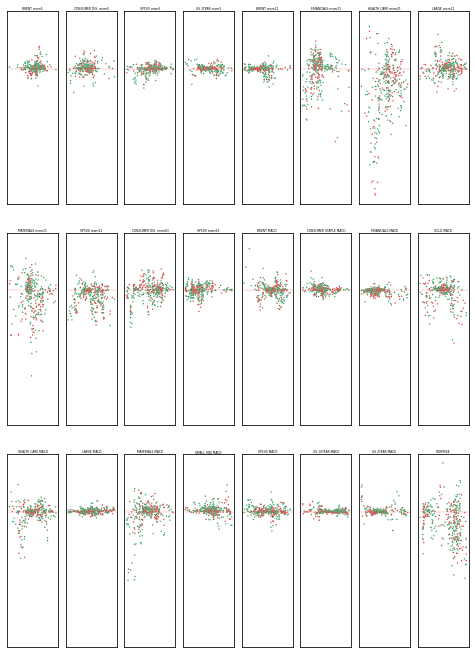

In [97]:
shap_values = shap_values_test
good_bad = good_bad_pred_rf(rfc, X_test, y_test)

red = sns.color_palette('RdYlGn', 10)[0]
green = sns.color_palette('RdYlGn', 10)[-1]
pal = [green, red]

fig, axs = plt.subplots(math.ceil(len(features.columns) / 8), 8, figsize=(8.27, 11.69), sharex=False, sharey=True)
axs = axs.ravel()

for i, feature in enumerate(features.columns):
    df = pd.DataFrame()
    df['value'] = X_test[:, i]
    df['IG'] = shap_values[:, i]
    df['GOOD_BAD'] = good_bad
    df.GOOD_BAD = df.GOOD_BAD.replace({1:'GOOD', 0:'BAD'})
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='GOOD_BAD', s=2, legend=False, palette=pal)

    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    
    axs[i].set_title(feature, fontsize=3, pad=2)

# fig.delaxes(axs[-3])
# fig.delaxes(axs[-2])
# fig.delaxes(axs[-1])

plt.subplots_adjust(wspace=0.15, hspace=0.15)
plt.savefig('plots/RF_features_importances_test.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

In [98]:
list(features.columns)

['BRENT mom5',
 'CONSUMER DIS. mom5',
 'SP500 mom5',
 'US 2YEAR mom5',
 'BRENT mom21',
 'FINANCIALS mom21',
 'HEALTH CARE mom21',
 'LARGE mom21',
 'MATERIALS mom21',
 'SP500 mom21',
 'CONSUMER DIS. mom63',
 'SP500 mom63',
 'BRENT MACD',
 'CONSUMER STAPLE MACD',
 'FINANCIALS MACD',
 'GOLD MACD',
 'HEALTH CARE MACD',
 'LARGE MACD',
 'MATERIALS MACD',
 'SMALL_MID MACD',
 'SP500 MACD',
 'US 10YEAR MACD',
 'US 2YEAR MACD',
 'SURPRISE']

# Neural Networks

In [99]:
train_indices, test_indices, _, _ = train_test_split(range(len(y)), y, test_size=0.2, shuffle=False)
X_train, y_train, X_test, y_test = X[train_indices], y[train_indices], X[test_indices], y[test_indices]

X_mean = X_train.mean(dim=[0], keepdim=True)
X_std = X_train.std(dim=[0], keepdim=True)
X_train = X_train.sub_(X_mean).div_(X_std)
X_test = X_test.sub_(X_mean).div_(X_std)

In [100]:
print('Train period :', index[train_indices][0].date(), 'to', index[train_indices][-1].date())
print('Test period :', index[test_indices][0].date(), 'to', index[test_indices][-1].date())

Train period : 2013-12-27 to 2020-06-05
Test period : 2020-06-08 to 2021-12-20


In [101]:
class MLP1(nn.Module):
    def __init__(self, nbr_features, pdrop=0.1, hidden_size=5):
        super().__init__()

        self.fc1 = nn.Linear(nbr_features, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 1)
        
        self.drop1 = nn.Dropout(pdrop)
        self.drop2 = nn.Dropout(pdrop)
        self.drop3 = nn.Dropout(pdrop)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        
        self.sigmoid = nn.Sigmoid()
        
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.relu1(self.bn1(self.drop1(self.fc1(x))))
        x = self.relu2(self.bn2(self.drop2(self.fc2(x))))
        x = self.relu3(self.drop3(self.fc3(x)))
        x = self.sigmoid(self.fc4(x))       

        return x.squeeze()

In [102]:
class MLP2(nn.Module):
    def __init__(self, nbr_features, pdrop=0.1, hidden_size=10):
        super().__init__()

        self.fc1 = nn.Linear(nbr_features, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 1)
        
        self.drop1 = nn.Dropout(pdrop)
        self.drop2 = nn.Dropout(pdrop)
        self.drop3 = nn.Dropout(pdrop)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        
        self.sigmoid = nn.Sigmoid()
        
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        
    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.relu1(self.bn1(self.drop1(self.fc1(x))))
        x = self.relu2(self.bn2(self.drop2(self.fc2(x))))
        x = self.relu3(self.drop3(self.fc3(x)))
        x = self.sigmoid(self.fc4(x))       

        return x.squeeze()

In [103]:
class MLP3(nn.Module):
    def __init__(self, nbr_features, pdrop=0.1, hidden_size=50):
        super().__init__()

        self.fc1 = nn.Linear(nbr_features, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 1)
        
        self.drop1 = nn.Dropout(pdrop)
        self.drop2 = nn.Dropout(pdrop)
        self.drop3 = nn.Dropout(pdrop)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        
        self.sigmoid = nn.Sigmoid()
        
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.relu1(self.bn1(self.drop1(self.fc1(x))))
        x = self.relu2(self.bn2(self.drop2(self.fc2(x))))
        x = self.relu3(self.drop3(self.fc3(x)))
        x = self.sigmoid(self.fc4(x))       

        return x.squeeze()

In [104]:
eta = 1e-3
weight_decay = 1e-4
dropout = 0.2
batch_size = 20
nb_epochs = 100

verbose = 3

nbr_features = X.size(1)

model_MLP1 = MLP1(nbr_features, pdrop=dropout)
model_MLP2 = MLP2(nbr_features, pdrop=dropout)
model_MLP3 = MLP3(nbr_features, pdrop=dropout)

train(model_MLP1, X_train, y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
      batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)

train(model_MLP2, X_train, y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
      batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)

train(model_MLP3, X_train, y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
      batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)

100%|██████████| 100/100 [00:13<00:00,  7.54it/s]


In [111]:
model_MLP1.eval()
print(f' MLP Accuracy on train set : {output_to_accu(model_MLP1, X_train, y_train):.2f} %')
print(f' MLP Accuracy on test set : {output_to_accu(model_MLP1, X_test, y_test):.2f} %')

model_MLP2.eval()
print(f' MLP Accuracy on train set : {output_to_accu(model_MLP2, X_train, y_train):.2f} %')
print(f' MLP Accuracy on test set : {output_to_accu(model_MLP2, X_test, y_test):.2f} %')

model_MLP3.eval()
print(f' MLP Accuracy on train set : {output_to_accu(model_MLP3, X_train, y_train):.2f} %')
print(f' MLP Accuracy on test set : {output_to_accu(model_MLP3, X_test, y_test):.2f} %')

 MLP Accuracy on train set : 72.34 %
 MLP Accuracy on test set : 50.15 %
 MLP Accuracy on train set : 76.63 %
 MLP Accuracy on test set : 50.46 %
 MLP Accuracy on train set : 88.89 %
 MLP Accuracy on test set : 49.85 %


In [112]:
def IG_barplot(model_list, X_test):  
    
    fig, axs = plt.subplots(1, len(model_list), figsize=(20,30), sharex=True, sharey=True)
    axs = axs.ravel()
    for i, model in enumerate(model_list):
        model.eval()
        ig = IntegratedGradients(model)
        attr = np.abs(ig.attribute(X_test, return_convergence_delta=False).detach().numpy())
        std = np.std(attr, axis=0)
        
        attr_matrix = np.mean(np.abs(attr), axis=0)

        sns.barplot(ax=axs[i], y=features.columns, x=attr_matrix, yerr=std, color='r', orient='h')
        axs[i].tick_params(length=0)
        axs[i].set_title(model.__class__.__name__)

    plt.show()

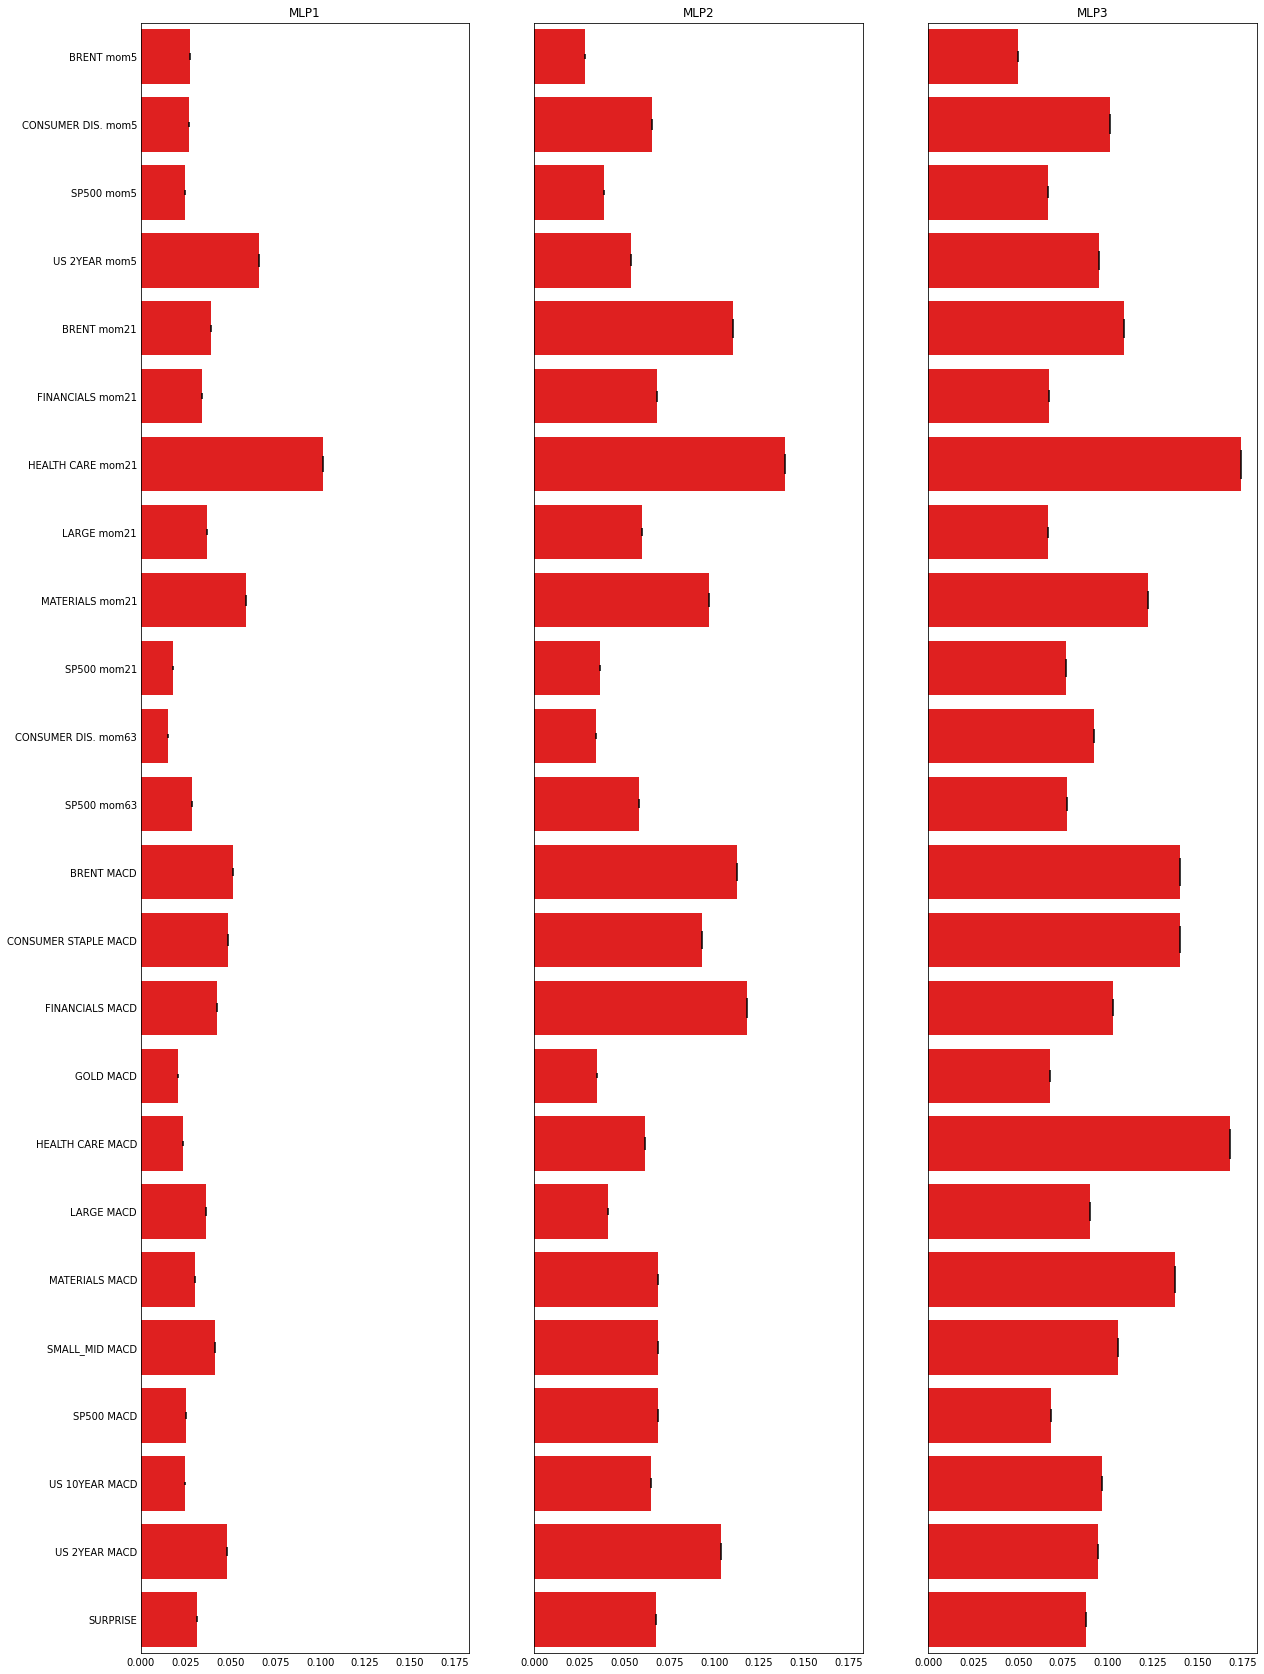

In [113]:
model_list = [model_MLP1, model_MLP2, model_MLP3]
IG_barplot(model_list, X_train)

In [114]:
ig = IntegratedGradients(model_MLP1)
attributes_train = ig.attribute(X_train, return_convergence_delta=False).detach().numpy()
attributes_test = ig.attribute(X_test, return_convergence_delta=False).detach().numpy()

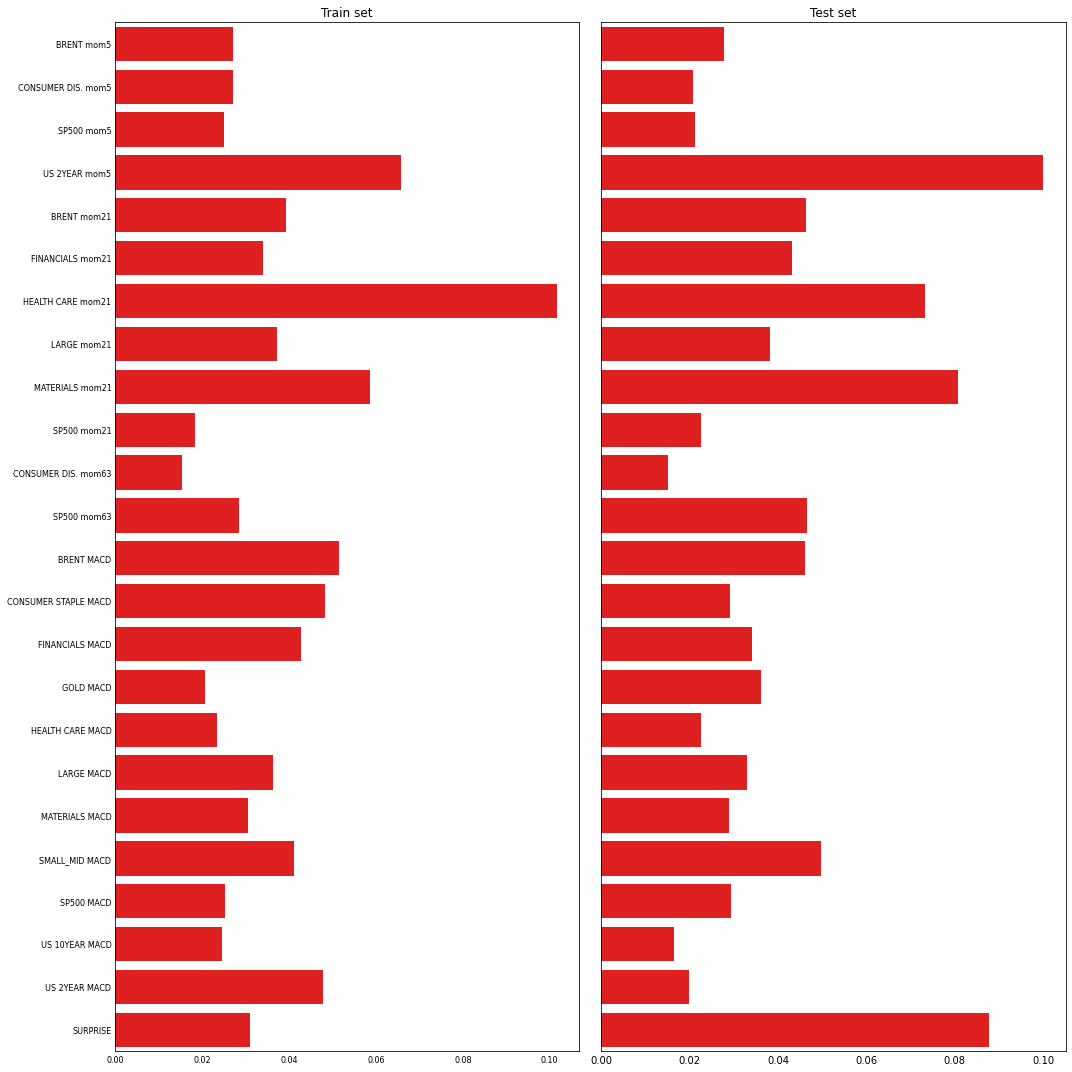

In [115]:
fig, axs = plt.subplots(1, 2, figsize=(15, 15), sharey=True)

attr_train = np.mean(np.abs(attributes_train), axis=0)
attr_test = np.mean(np.abs(attributes_test), axis=0)

sns.barplot(ax=axs[0], x=attr_train, y=features.columns, color='r')
axs[0].tick_params(length=0, labelsize=8)
axs[0].set_title('Train set')

sns.barplot(ax=axs[1], x=attr_test, y=features.columns, color='r')
axs[1].tick_params(length=0)
axs[1].set_title('Test set')

plt.tight_layout()
plt.show()

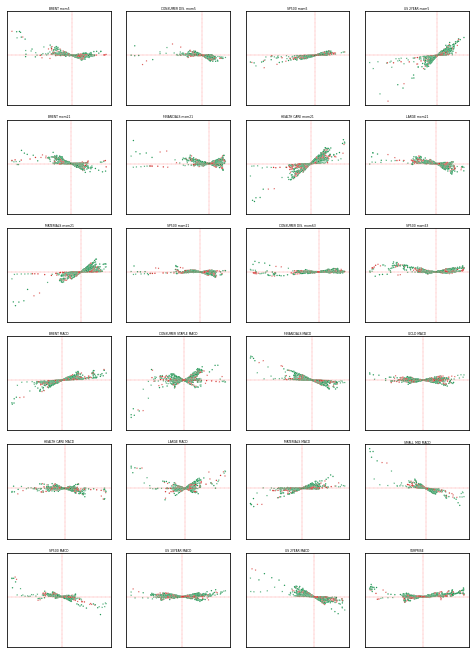

In [116]:
good_bad = good_bad_pred(model_MLP1, X_train, y_train)

fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(8.27, 11.69), sharex=False, sharey=True)
axs = axs.ravel()

for i, feature in enumerate(features.columns):
    df = pd.DataFrame()
    df['value'] = X_train[:, i]
    df['IG'] = attributes_train[:, i]
    df['GOOD_BAD'] = good_bad
    df['target'] = y_train
    df.GOOD_BAD = df.GOOD_BAD.replace({1:'Good', 0:'Bad'})
    df.target = df.target.replace({1:'Large', 0:'Small'})
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='GOOD_BAD', style='target', s=2, 
                    palette=list(reversed(pal)), legend=False, edgecolors=None)
    
    axs[i].axvline(x=0., linestyle='--', color='r', lw=0.25)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(feature, fontsize=3, pad=2)

# fig.delaxes(axs[-3])
# fig.delaxes(axs[-2])
# fig.delaxes(axs[-1])

plt.subplots_adjust(wspace=0.15, hspace=0.15)

plt.savefig('plots/MLP_features_importances_train.png', format='png', bbox_inches='tight', dpi=500, facecolor='white')
plt.show()

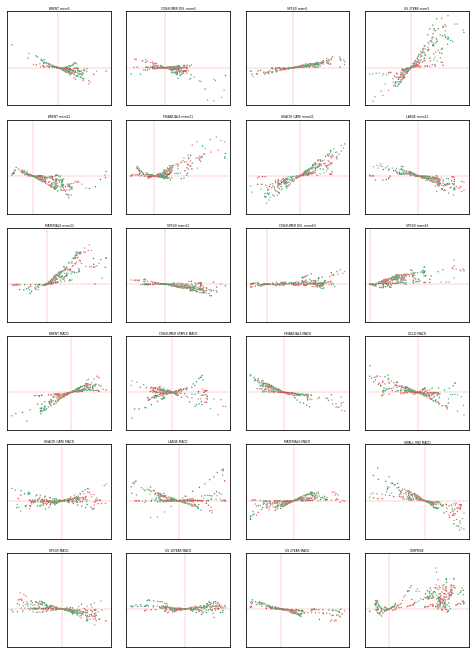

In [117]:
good_bad = good_bad_pred(model_MLP1, X_test, y_test)

fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(8.27, 11.69), sharex=False, sharey=True)
axs = axs.ravel()

for i, feature in enumerate(features.columns):
    df = pd.DataFrame()
    df['value'] = X_test[:, i]
    df['IG'] = attributes_test[:, i]
    df['GOOD_BAD'] = good_bad
    df['target'] = y_test
    df.GOOD_BAD = df.GOOD_BAD.replace({1:'Good', 0:'Bad'})
    df.target = df.target.replace({1:'Large', 0:'Small'})
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='GOOD_BAD', s=2, style='target',
                    palette=list(reversed(pal)), legend=False, edgecolors=None)
    
    axs[i].axvline(x=0., linestyle='--', color='r', lw=0.25)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].set_title(feature, fontsize=3, pad=2)

# fig.delaxes(axs[-3])
# fig.delaxes(axs[-2])
# fig.delaxes(axs[-1])

plt.subplots_adjust(wspace=0.15, hspace=0.15)
plt.savefig('plots/MLP_features_importances_test.png', format='png', bbox_inches='tight', dpi=500, facecolor='white')

plt.show()

# LSTM WITH SEQUENTIAL INPUT

In [118]:
input_period = 21

last_date_train = target_prices.index[-1]

num_features = len(features.columns)

forward_weekly_returns = target_prices.rolling(5).apply(lambda x: np.log(x[-1] / x[0]) / len(x)).shift(-5)
forward_weekly_returns['abs_diff'] = np.abs(forward_weekly_returns.SMALL_MID - forward_weekly_returns.LARGE)

best_pred = (forward_weekly_returns.SMALL_MID > forward_weekly_returns.LARGE).astype(int)

start_date = last_date_train - relativedelta(years=training_window)

df_output = best_pred.loc[start_date:]
final_index = list(df_output.reset_index()[forward_weekly_returns.loc[start_date:].reset_index().abs_diff > 0.0005].index)

# start_date_input = target_prices.loc[:start_date].index[0]

df_input = features.loc[:df_output.index[-1]]

X = []

for idx in df_output.index:

    df_input_period = df_input.loc[:idx].iloc[-input_period:]
    X_period = df_input_period.values.reshape(input_period, num_features)
    X.append(X_period)

X = np.array(X)
X = X[final_index]
y = df_output.values
y = y[final_index]

X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float()

In [119]:
train_indices, test_indices, _, _ = train_test_split(range(len(y)), y, test_size=0.2, shuffle=False, random_state=1)
X_train, y_train, X_test, y_test = X[train_indices], y[train_indices], X[test_indices], y[test_indices]
print('Number of train sample', len(X_train))
print('Number of test sample', len(X_test))

X_mean = X_train.mean(dim=[0, 1], keepdim=True)
X_std = X_train.std(dim=[0, 1], keepdim=True)
X_train = X_train.sub_(X_mean).div_(X_std)
X_test = X_test.sub_(X_mean).div_(X_std)

class_count_train = np.unique(y_train.cpu(), axis=0, return_counts=True)[1]
class_count_test = np.unique(y_test.cpu(), axis=0, return_counts=True)[1]
weights_train = torch.tensor(class_count_train / sum(class_count_train))
weights_test = torch.tensor(class_count_test / sum(class_count_test))
print('Allocation of best returns in train set :', weights_train.cpu().numpy())
print('Allocation of best returns in test set :', weights_test.cpu().numpy())

Number of train sample 1305
Number of test sample 327
Allocation of best returns in train set : [0.464 0.536]
Allocation of best returns in test set : [0.453 0.547]


In [155]:
class LSTM1(nn.Module):

    def __init__(self, nbr_features, hidden_size=10, num_layers=2, pdrop=0.1):
        super(LSTM1, self).__init__()
        
        self.nbr_features = nbr_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = pdrop
        self.device = device
        self.lstm = nn.LSTM(input_size=self.nbr_features, hidden_size=self.hidden_size, 
                            num_layers=self.num_layers, batch_first=True, dropout=self.dropout)
        self.fc = nn.Linear(hidden_size, 1)

        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.size(0), x.size(1), x.size(2))
        x, _ = self.lstm(x)
        x = self.sigmoid(self.fc(x[:, -1, :]))

        return x.squeeze()

In [156]:
class LSTM2(nn.Module):

    def __init__(self, nbr_features, hidden_size=50, num_layers=2, pdrop=0.1):
        super(LSTM2, self).__init__()
        
        self.nbr_features = nbr_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = pdrop
        self.device = device
        self.lstm = nn.LSTM(input_size=self.nbr_features, hidden_size=self.hidden_size, 
                            num_layers=self.num_layers, batch_first=True, dropout=self.dropout)
        self.fc = nn.Linear(hidden_size, 1)

        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.size(0), x.size(1), x.size(2))
        x, _ = self.lstm(x)
        x = self.sigmoid(self.fc(x[:, -1, :]))

        return x.squeeze()

In [157]:
class LSTM3(nn.Module):

    def __init__(self, nbr_features, hidden_size=100, num_layers=3, pdrop=0.1):
        super(LSTM3, self).__init__()
        
        self.nbr_features = nbr_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = pdrop
        self.device = device
        self.lstm = nn.LSTM(input_size=self.nbr_features, hidden_size=self.hidden_size, 
                            num_layers=self.num_layers, batch_first=True, dropout=self.dropout)
        self.fc = nn.Linear(hidden_size, 1)

        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size)
        # c0 = torch.randn(self.num_layers, x.size(0), self.hidden_size)
        x = x.view(x.size(0), x.size(1), x.size(2))
        x, _ = self.lstm(x)
        x = self.sigmoid(self.fc(x[:, -1, :]))

        return x.squeeze()

In [158]:
eta = 1e-3
weight_decay = 1e-4
dropout = 0.2
batch_size = 20
nb_epochs = 20

verbose = 3

nbr_features = X.size(2)

model_LSTM1 = LSTM1(nbr_features, pdrop=dropout)
model_LSTM2 = LSTM2(nbr_features, pdrop=dropout)
model_LSTM3 = LSTM3(nbr_features, pdrop=dropout)

train(model_LSTM1, X_train, y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
      batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)
train(model_LSTM2, X_train, y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
      batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)
train(model_LSTM3, X_train, y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
      batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)

100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


In [162]:
model_LSTM1.eval()
print(f' LSTM1 Accuracy on train set : {output_to_accu(model_LSTM1, X_train, y_train):.2f} %')
print(f' LSTM1 Accuracy on test set : {output_to_accu(model_LSTM1, X_test, y_test):.2f} %')

model_LSTM2.eval()
print(f' LSTM2 Accuracy on train set : {output_to_accu(model_LSTM2, X_train, y_train):.2f} %')
print(f' LSTM2 Accuracy on test set : {output_to_accu(model_LSTM2, X_test, y_test):.2f} %')

model_LSTM3.eval()
print(f' LSTM3 Accuracy on train set : {output_to_accu(model_LSTM3, X_train, y_train):.2f} %')
print(f' LSTM3 Accuracy on test set : {output_to_accu(model_LSTM3, X_test, y_test):.2f} %')

 LSTM1 Accuracy on train set : 79.08 %
 LSTM1 Accuracy on test set : 58.41 %
 LSTM2 Accuracy on train set : 90.57 %
 LSTM2 Accuracy on test set : 51.38 %
 LSTM3 Accuracy on train set : 90.57 %
 LSTM3 Accuracy on test set : 55.05 %


In [161]:
ig = IntegratedGradients(model_LSTM1)
attributes_train = ig.attribute(X_train, return_convergence_delta=False).detach().numpy()
attributes_test = ig.attribute(X_test, return_convergence_delta=False).detach().numpy()

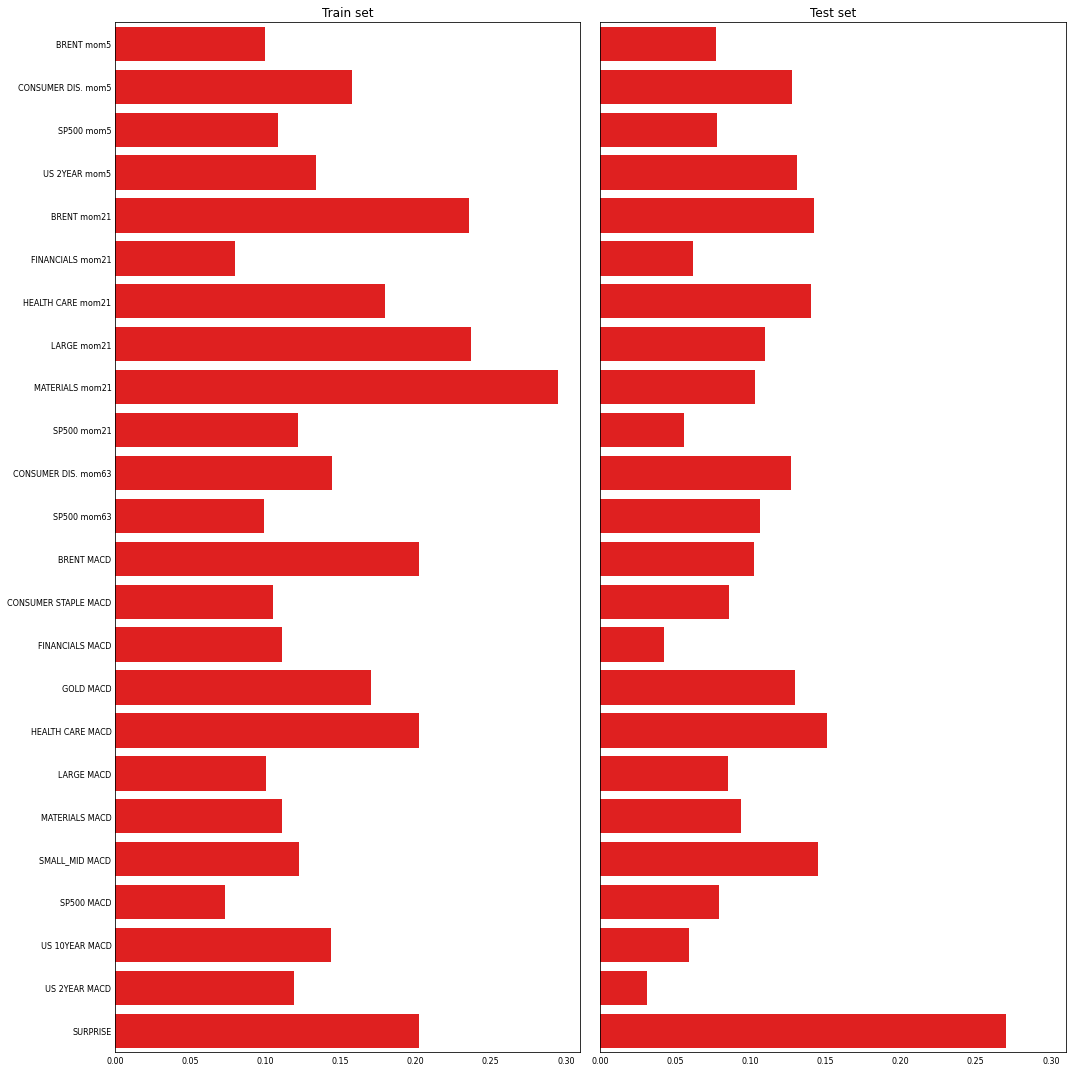

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(15, 15), sharey=True, sharex=True)

attr_train = np.sum(np.mean(np.abs(attributes_train), axis=0), axis=0)
attr_test = np.sum(np.mean(np.abs(attributes_test), axis=0), axis=0)

sns.barplot(ax=axs[0], x=attr_train, y=features.columns, color='r')
axs[0].tick_params(length=0, labelsize=8)
axs[0].set_title('Train set')

sns.barplot(ax=axs[1], x=attr_test, y=features.columns, color='r')
axs[1].tick_params(length=0, labelsize=8)
axs[1].set_title('Test set')

plt.tight_layout()
plt.show()

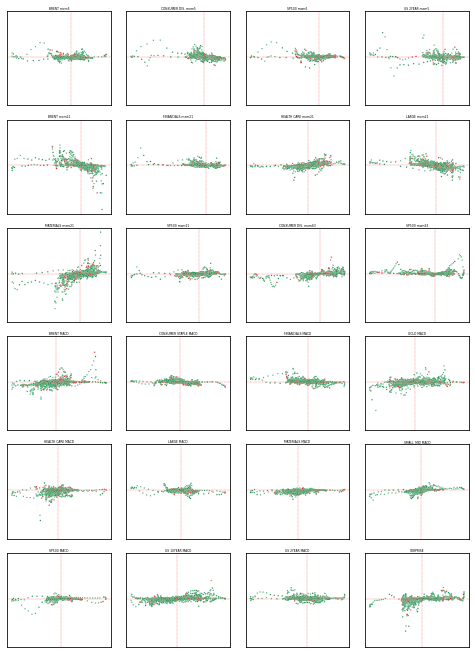

In [65]:
good_bad = good_bad_pred(model_LSTM1, X_train, y_train)

fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(8.27, 11.69), sharex=False, sharey=True)
axs = axs.ravel()

for i, feature in enumerate(features.columns):
    df = pd.DataFrame()
    df['value'] = X_train.mean(axis=1)[:, i]
    df['IG'] = np.sum(attributes_train, axis=1)[:, i]
    df['GOOD_BAD'] = good_bad
    df['target'] = y_train
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='GOOD_BAD', style='target',
                    s=2, legend=False, edgecolors=None, palette=list(reversed(pal)))
    
    axs[i].axvline(x=0., linestyle='--', color='r', lw=0.25)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(feature, fontsize=3, pad=2)

# fig.delaxes(axs[-3])
# fig.delaxes(axs[-2])
# fig.delaxes(axs[-1])

plt.subplots_adjust(wspace=0.15, hspace=0.15)

plt.savefig('plots/LSTM_features_importances_train.png', format='png', bbox_inches='tight', dpi=500, facecolor='white')
plt.show()

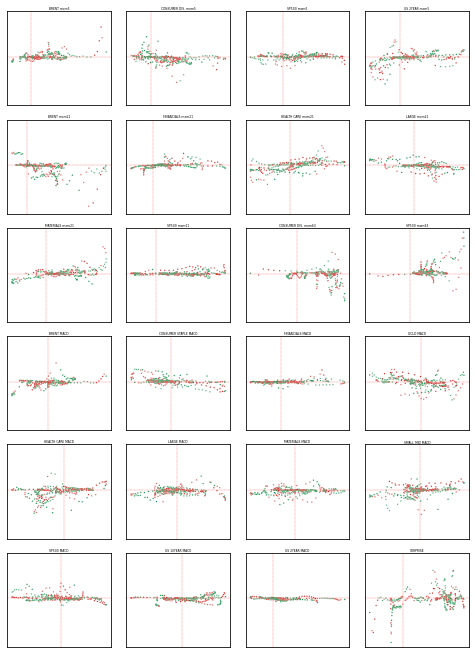

In [66]:
good_bad = good_bad_pred(model_LSTM1, X_test, y_test)

fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(8.27, 11.69), sharex=False, sharey=True)
axs = axs.ravel()

for i, feature in enumerate(features.columns):
    df = pd.DataFrame()
    df['value'] = X_test.mean(axis=1)[:, i]
    df['IG'] = np.sum(attributes_test, axis=1)[:, i]
    df['GOOD_BAD'] = good_bad
    df['target'] = y_test
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='GOOD_BAD', style='target',
                    s=2, legend=False, edgecolors=None, palette=list(reversed(pal)))
    
    axs[i].axvline(x=0., linestyle='--', color='r', lw=0.25)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(feature, fontsize=3, pad=2)

# fig.delaxes(axs[-3])
# fig.delaxes(axs[-2])
# fig.delaxes(axs[-1])

plt.subplots_adjust(wspace=0.15, hspace=0.15)

plt.savefig('plots/LSTM_features_importances_train.png', format='png', bbox_inches='tight', dpi=500, facecolor='white')
plt.show()

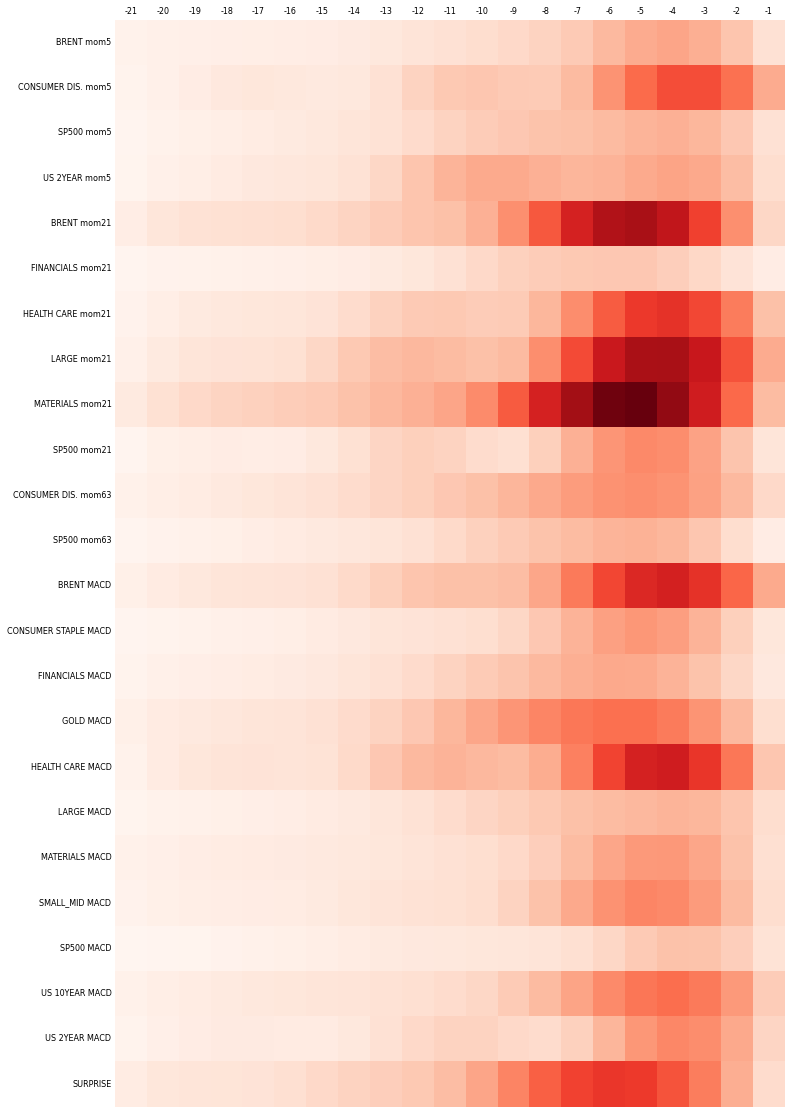

In [67]:
attr = np.mean(np.abs(attributes_train), axis=0).T

fig, ax = plt.subplots(figsize=(12,20))
sns.heatmap(data=attr, annot=False, cmap='Reds', cbar=False, 
            yticklabels=features.columns, xticklabels=list(reversed(- (np.arange(input_period) + 1))))

ax.tick_params(axis='both', which='major', labelsize=8, labelleft=True, labeltop=True, labelbottom=False, rotation=0, length=0)

plt.show()

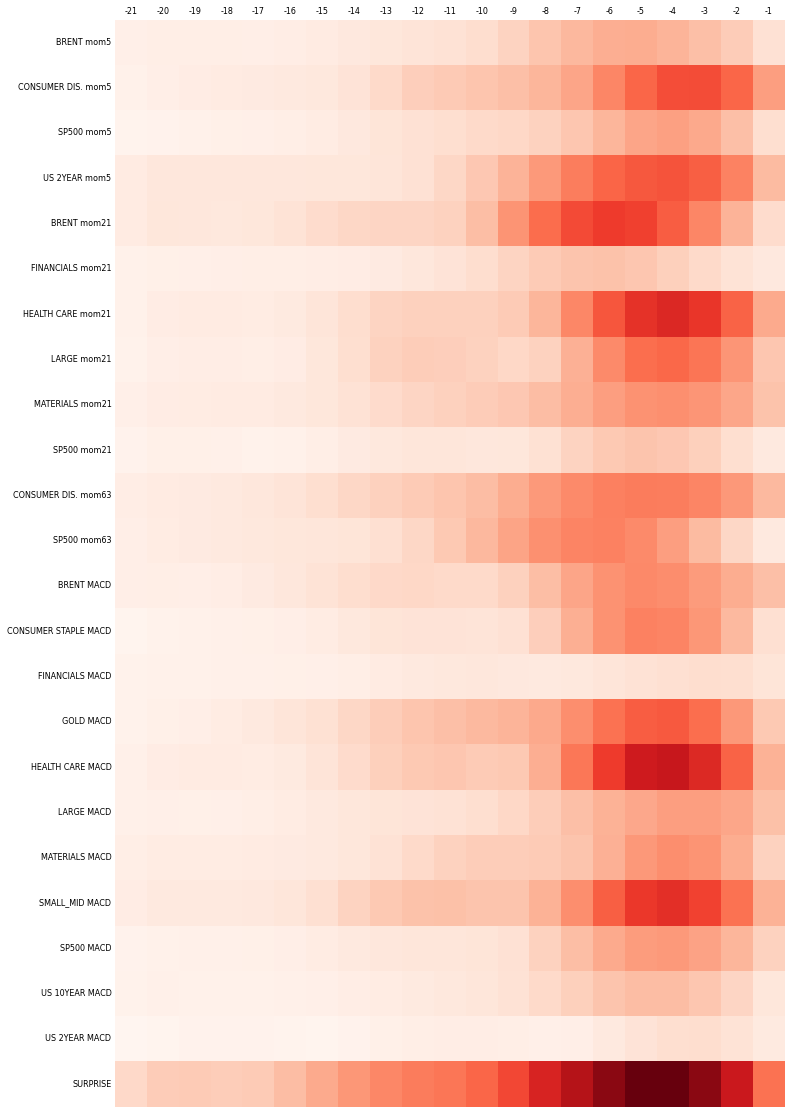

In [68]:
attr = np.mean(np.abs(attributes_test), axis=0).T

fig, ax = plt.subplots(figsize=(12,20))
sns.heatmap(data=attr, annot=False, cmap='Reds', cbar=False, 
            yticklabels=features.columns, xticklabels=list(reversed(- (np.arange(input_period) + 1))))

ax.tick_params(axis='both', which='major', labelsize=8, labelleft=True, labeltop=True, labelbottom=False, rotation=0, length=0)

plt.show()